# Visualizing USDC Transfers on Ethereum Mainnet

Last updated: June 12, 2025

Created by: [Open Source Observer](https://www.opensource.observer)

---

### Introduction

This tutorial is an extension of [Banteg's 2023 analysis](https://banteg.xyz/posts/heatmap/) of 2.1 billion native ether transfers. Here we provide a Colab-based implementation that you can easily modify to create a beautiful heatmap of any ERC20 token contract on any EVM network.

### Data sources

This tutorial uses the `logs` table in Google's public [Ethereum blockchain dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/blockchain-analytics-ethereum-mainnet-us?project=opensource-observer&inv=1&invt=Abz6yA).

### What's included in this tutorial?

This tutorial covers the following use cases for analyzing crypto data on BigQuery:

- How to identify events that involve a specific ERC20 token contract
- How to filter on specific event signatures included in the `topics` field
- How to decode hex values
- How to make beautiful data visualization!

### Key resources

- Open Source Observer's curated [catalog of public datasets](https://docs.opensource.observer/docs/integrate/datasets/) on BigQuery

- Google's [Ethereum blockchain dataset](https://console.cloud.google.com/marketplace/product/bigquery-public-data/blockchain-analytics-ethereum-mainnet-us?project=opensource-observer&inv=1&invt=Abz6yA) on BigQuery

- The [Ethereum Signature Database](https://www.4byte.directory/event-signatures/?bytes_signature=0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef), maintained by [beaconcha.in](https://beaconcha.in/)

- Etherscan block explorer for looking up details about the [USDC contract](https://etherscan.io/address/0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48)

- Banteg's [original blogpost](https://banteg.xyz/posts/heatmap/), which served as inspiration for this tutorial

- Cmasher [docs](https://cmasher.readthedocs.io/user/usage.html), if you want to play with additional color maps




# Getting started

We will use **uv** to quickly install two packages to help us with our data visualization.

We will also test that the connection to your BigQuery project is working.

In [1]:
# Install and import dependencies

! uv pip install cmasher datashader
import cmasher
import datashader as ds
from datashader import transfer_functions as tf
import pandas as pd

Using Python 3.11.13 environment at: /usr
Audited 2 packages in 230ms


/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [2]:
# Quick test to see if you are connected

# Replace with your project name ↘↘↘
%%bigquery df_test --project opensource-observer

SELECT *
FROM `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
WHERE block_timestamp BETWEEN '2025-06-01' AND '2025-06-02'
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
# Preview the data

df_test

block_hash  block_number  \
0  0x00040559848bf787743e6afc5918d59f5fb134f14e8f...      22609331   
1  0x00040559848bf787743e6afc5918d59f5fb134f14e8f...      22609331   
2  0x00040559848bf787743e6afc5918d59f5fb134f14e8f...      22609331   
3  0x00040559848bf787743e6afc5918d59f5fb134f14e8f...      22609331   
4  0x00040559848bf787743e6afc5918d59f5fb134f14e8f...      22609331   

            block_timestamp  \
0 2025-06-01 10:43:11+00:00   
1 2025-06-01 10:43:11+00:00   
2 2025-06-01 10:43:11+00:00   
3 2025-06-01 10:43:11+00:00   
4 2025-06-01 10:43:11+00:00   

                                    transaction_hash  transaction_index  \
0  0x64c56fdbee67b997064da6e3cf4baf940ead969a8600...                206   
1  0x513203dbd763f8e7d997f0dd7730e3016fd53616b224...                  2   
2  0xb98897f64f5dab01a427842f4c360f92a83a141142e9...                 13   
3  0xf0d762737d8e1f6d0a397bffa14eec26ee1039370c14...                 30   
4  0x8873347efa7a4b82ea536eb414c0563e2730ff2babbd...                  9   

   log_index                                     address  \
0        393  0x4d4574f50dd8b9dbe623cf329dcc78d76935e610   
1         13  0xfd409bc96d126bc8a56479d4c7672015d539f96c   
2         38  0xfaba6f8e4a5e8ab82f62fe7c39859fa577269be3   
3         62  0x7c80a6a743b31e4dd1adff39a19e3d50678daefc   
4         32  0x6123b0049f904d730db3c36a31167d9d4121fa6b   

                                                data  \
0  0xffffffffffffffffffffffffffffffffffffffffffff...   
1  0x00000000000000000000000000000000000000000000...   
2  0x00000000000000000000000000000000000000000000...   
3  0x00000000000000000000000000000000000000000000...   
4  0x00000000000000000000000000000000000000000000...   

                                              topics  removed  
0  [0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b...    False  
1  [0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...    False  
2  [0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...    False  
3  [0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78...    False  
4  [0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c...    False

# Explore the data

Next we will perform some test queries to get comfortable working with the `logs` data and extracting the data we need.

Warning: this is a large database (>1 TB), so it's a good idea to ensure your test cases are working before you query the full dataset.

In [4]:
# Define some parameters we can use for testing

TEST_PARAMS = {
    'start_date': '2025-06-01', # Choose a recent date
    'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', # Circle USDC
    'topic': '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef', # Token transfer event signature
    'amount_scale': 1e6, # Scale the amount by this factor
}

In [5]:
# Test 1: Get a few rows of data

# Replace with your project name ↘↘↘
%%bigquery df_test1 --project opensource-observer --params $TEST_PARAMS

SELECT
  block_timestamp,
  transaction_hash,
  data
FROM `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
WHERE
  block_timestamp >= @start_date
  AND address = @address
  AND topics[OFFSET(0)] = @topic
  AND data != '0x'
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
df_test1

block_timestamp  \
0 2025-06-12 13:17:11+00:00   
1 2025-06-12 13:17:11+00:00   
2 2025-06-12 13:17:11+00:00   
3 2025-06-12 13:17:11+00:00   
4 2025-06-12 13:17:11+00:00   

                                    transaction_hash  \
0  0x97aa3eed9c41c366aad2a7a6875b862cd856f4ae6eba...   
1  0xbc20cac028dc936896cde42ff377cbd65a76487cedde...   
2  0x3d5492895d362566c0ab8ce630a68739346b290861e7...   
3  0x2cef9103f474aa62fd33f388e7767994198514d18eef...   
4  0x2cef9103f474aa62fd33f388e7767994198514d18eef...   

                                                data  
0  0x00000000000000000000000000000000000000000000...  
1  0x00000000000000000000000000000000000000000000...  
2  0x00000000000000000000000000000000000000000000...  
3  0x00000000000000000000000000000000000000000000...  
4  0x00000000000000000000000000000000000000000000...

In [7]:
# Test 2: Handle the hex to int conversion via a temp JS function

# Replace with your project name ↘↘↘
%%bigquery df_test2 --project opensource-observer --params $TEST_PARAMS

CREATE TEMP FUNCTION hex_to_decimal(hex_str STRING)
RETURNS STRING
LANGUAGE js AS """
  const h = hex_str.startsWith('0x') ? hex_str : '0x' + hex_str;
  return BigInt(h).toString();
""";

SELECT
  block_timestamp,
  transaction_hash,
  SAFE_CAST(hex_to_decimal(data) AS BIGINT) / @amount_scale AS amount
FROM `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
WHERE
  block_timestamp >= @start_date
  AND address = @address
  AND topics[OFFSET(0)] = @topic
  AND data != '0x'
ORDER BY 3 DESC
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
df_test2

block_timestamp  \
0 2025-06-11 08:38:11+00:00   
1 2025-06-11 08:38:11+00:00   
2 2025-06-11 08:38:11+00:00   
3 2025-06-11 08:38:11+00:00   
4 2025-06-11 23:34:59+00:00   

                                    transaction_hash        amount  
0  0x3c4440b527b06e9af58ea535c44cc87b2e1322c94205...  1.740000e+08  
1  0x73ee62b917637d1d0439564d9323f4b63f34fe823e46...  1.740000e+08  
2  0x6df4dde6ae1b20baa8f49886fbd4617f2461bcd4451c...  1.740000e+08  
3  0xb0c61c0338b7c271973bc8d2acd8e66d1f4e57e1e1e7...  1.740000e+08  
4  0x6873393469013e8d57d10173eed51a2482bea78e68f7...  1.656708e+08

In [9]:
# Test 3: Group the data by block to reduce size of the response

# Replace with your project name ↘↘↘
%%bigquery df_test3 --project opensource-observer --params $TEST_PARAMS

CREATE TEMP FUNCTION hex_to_decimal(hex_str STRING)
RETURNS STRING
LANGUAGE js AS """
  const h = hex_str.startsWith('0x') ? hex_str : '0x' + hex_str;
  return BigInt(h).toString();
""";

WITH events AS (
  SELECT
    block_timestamp,
    transaction_hash,
    SAFE_CAST(hex_to_decimal(data) AS BIGINT) / @amount_scale AS amount
  FROM `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
  WHERE
    block_timestamp >= @start_date
    AND address = @address
    AND topics[OFFSET(0)] = @topic
    AND data != '0x'
)
SELECT
  block_timestamp,
  count(*) AS count,
  SUM(amount) AS amount
FROM events
GROUP BY block_timestamp
ORDER BY block_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
df_test3.tail()

block_timestamp  count        amount
82744 2025-06-12 14:26:47+00:00     10  1.039247e+04
82745 2025-06-12 14:26:59+00:00     65  1.661034e+06
82746 2025-06-12 14:27:11+00:00     38  1.653487e+06
82747 2025-06-12 14:27:23+00:00     49  3.525540e+05
82748 2025-06-12 14:27:35+00:00     24  3.420755e+05

# Create the heatmap

Now we are confident in our test data and can execute the full query.

We'll do some basic transformations and then visualize the heatmap!

In [11]:
PARAMS = {
    'start_date': '2018-08-01', # Date the contract was deployed
    'address': '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48', # Circle USDC
    'topic': '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef', # Token transfer event signature
    'amount_scale': 1e6, # Scale the amount by this factor
}

In [12]:
# Execute the full query

# Replace with your project name ↘↘↘
%%bigquery df --project opensource-observer --params $PARAMS

CREATE TEMP FUNCTION hex_to_decimal(hex_str STRING)
RETURNS STRING
LANGUAGE js AS """
  const h = hex_str.startsWith('0x') ? hex_str : '0x' + hex_str;
  return BigInt(h).toString();
""";

WITH events AS (
  SELECT
    block_timestamp,
    transaction_hash,
    SAFE_CAST(hex_to_decimal(data) AS BIGINT) / @amount_scale AS amount
  FROM `bigquery-public-data.goog_blockchain_ethereum_mainnet_us.logs`
  WHERE
    block_timestamp >= @start_date
    AND address = @address
    AND topics[OFFSET(0)] = @topic
    AND data != '0x'
)
SELECT
  block_timestamp,
  count(*) AS count,
  SUM(amount) AS amount
FROM events
GROUP BY block_timestamp
ORDER BY block_timestamp

Query is running:   0%|          |

Downloading:   0%|          |

In [13]:
df.tail()

block_timestamp  count        amount
13145623 2025-06-12 14:26:47+00:00     10  1.039247e+04
13145624 2025-06-12 14:26:59+00:00     65  1.661034e+06
13145625 2025-06-12 14:27:11+00:00     38  1.653487e+06
13145626 2025-06-12 14:27:23+00:00     49  3.525540e+05
13145627 2025-06-12 14:27:35+00:00     24  3.420755e+05

In [14]:
# Extract the day number and hour

start_datetime = pd.to_datetime(PARAMS['start_date'])
df['day'] = df['block_timestamp'].apply(lambda x: (x.date() - start_datetime.date()).days)
df['hour'] = df['block_timestamp'].dt.hour + df['block_timestamp'].dt.minute/60
df.tail()

block_timestamp  count        amount   day       hour
13145623 2025-06-12 14:26:47+00:00     10  1.039247e+04  2507  14.433333
13145624 2025-06-12 14:26:59+00:00     65  1.661034e+06  2507  14.433333
13145625 2025-06-12 14:27:11+00:00     38  1.653487e+06  2507  14.450000
13145626 2025-06-12 14:27:23+00:00     49  3.525540e+05  2507  14.450000
13145627 2025-06-12 14:27:35+00:00     24  3.420755e+05  2507  14.450000

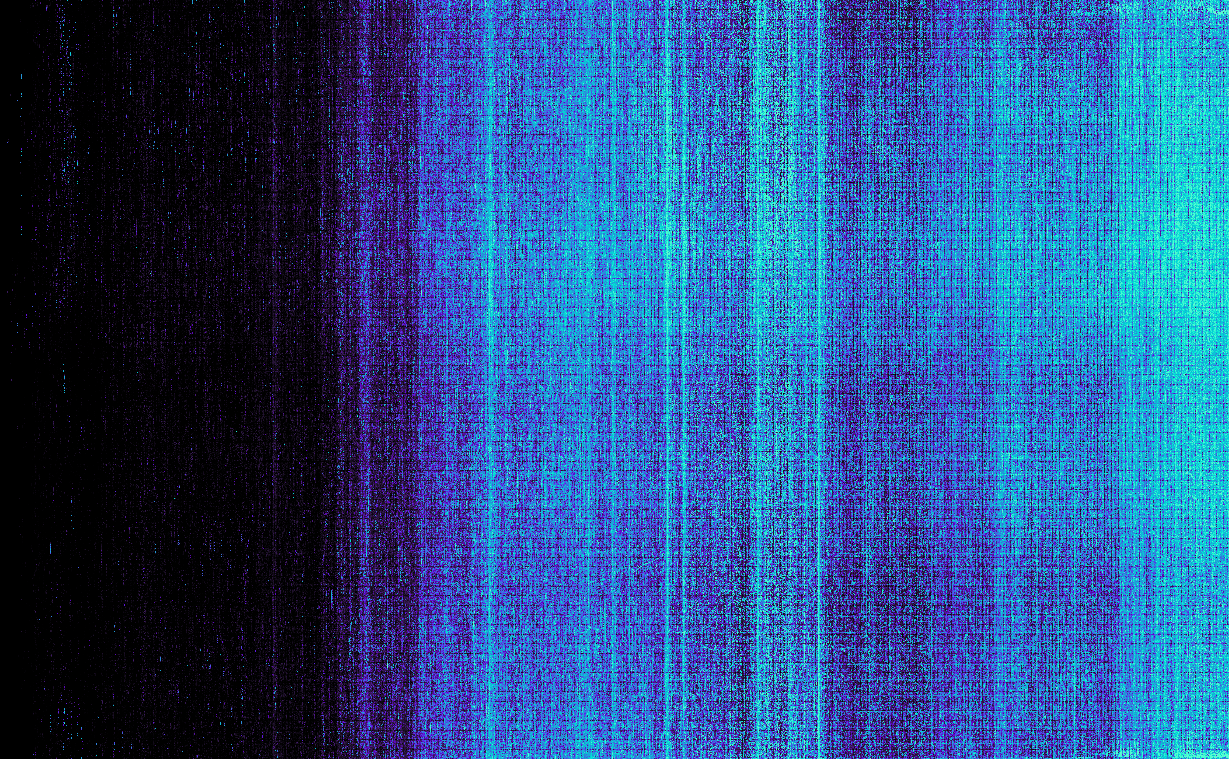

In [15]:
# Make the heatmap

# Set the color map (there are many options to choose from)
CMAP = cmasher.cosmic

# Get the image dimensions
aspect = (1 + 5**0.5) / 2
width = int(df['day'].nunique() / 2)
height = int(width / aspect)
canvas = ds.Canvas(plot_width=width, plot_height=height)

# Plot the pixels
VAR = "amount" # or "count"
points = canvas.points(df, "day", "hour", agg=ds.sum(VAR)).fillna(0)
heatmap = tf.shade(points, cmap=CMAP)

# Render the heatmap in the notebook
heatmap